In [1]:
import urllib
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import sklearn
import libpysal as lps

In [2]:
from shapely.geometry import Point
from fiona.crs import from_epsg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib.colors import ListedColormap
from requests import get
from urllib.parse import urlparse

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

In [4]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [ ]:
def cache_data(src:str, dest:str) -> str:    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    if not os.path.isfile(dfn):        
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)            
        print('Done downloading...')
    else:
        print(f"Found {dfn} locally!")
    return dfn

ddir  = os.path.join('data','rawdata') # destination directory
spath = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip' # source path
boros = gpd.read_file( cache_data(spath+'?raw=true', ddir) )
print('Done.')

In [155]:
dfward = gpd.read_file( os.path.join('data','London-wards-2018_ESRI','London_Ward.shp'))
print(f"Data frameW is {dfward.shape[0]:,} x {dfward.shape[1]}")
print(list(dfward.columns.values))

Data frameW is 657 x 7
['NAME', 'GSS_CODE', 'DISTRICT', 'LAGSSCODE', 'HECTARES', 'NONLD_AREA', 'geometry']


In [6]:
# Set download URL
urlcrime = 'https://data.london.gov.uk/download/recorded_crime_summary/866c05de-c5cd-454b-8fe5-9e7c77ea2313/MPS%20Ward%20Level%20Crime%20%28most%20recent%2024%20months%29.csv'
dfcrime = pd.read_csv(urlcrime, low_memory=False)

# check the columns of dataframe
print(f"Data frameC is {dfcrime.shape[0]:,} x {dfcrime.shape[1]}")
print(list(dfcrime.columns.values))

Data frameC is 22,410 x 29
['MajorText', 'MinorText', 'WardName', 'WardCode', 'LookUp_BoroughName', '201901', '201902', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012']


In [8]:
urlairbnb = 'http://data.insideairbnb.com/united-kingdom/england/london/2019-12-09/data/listings.csv.gz'
dfair = pd.read_csv(urlairbnb, low_memory=False)

print(f"Data frameA is {dfair.shape[0]:,} x {dfair.shape[1]}")
print(list(dfair.columns.values))

Data frameA is 86,469 x 106
['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekl

In [9]:
urlpop = 'https://data.london.gov.uk/download/ward-profiles-and-atlas/772d2d64-e8c6-46cb-86f9-e52b4c7851bc/ward-profiles-excel-version.csv'
dfpop = pd.read_csv(urlpop, low_memory=False, encoding = "latin1")

print(f"Data frameP is {dfpop.shape[0]:,} x {dfpop.shape[1]}")
print(list(dfpop.columns.values))

Data frameP is 660 x 67
['Ward name', 'Old code', 'New code', 'Population - 2015', 'Children aged 0-15 - 2015', 'Working-age (16-64) - 2015', 'Older people aged 65+ - 2015', '% All Children aged 0-15 - 2015', '% All Working-age (16-64) - 2015', '% All Older people aged 65+ - 2015', 'Mean Age - 2013', 'Median Age - 2013', 'Area - Square Kilometres', 'Population density (persons per sq km) - 2013', '% BAME - 2011', '% Not Born in UK - 2011', '% English is First Language of no one in household - 2011', 'General Fertility Rate - 2013', 'Male life expectancy -2009-13', 'Female life expectancy -2009-13 ', '% children in reception year who are obese - 2011/12 to 2013/14', '% children in year 6 who are obese- 2011/12 to 2013/14', 'Rate of All Ambulance Incidents per 1,000 population - 2014', 'Rates of ambulance call outs for alcohol related illness - 2014', 'Number Killed or Seriously Injured on the roads - 2014', 'In employment (16-64) - 2011', 'Employment rate (16-64) - 2011', 'Number of job

In [10]:
# Set download URL
urldwe = 'https://data.london.gov.uk/download/dwellings-council-tax-band-wards/b1b9ea17-3fbb-4ecc-bf19-5246a3cf745b/dwellings-council-band-ward.csv'
dfdwe = pd.read_csv(urldwe, low_memory=False)

# check the columns of dataframe
print(f"Data frameC is {dfdwe.shape[0]:,} x {dfdwe.shape[1]}")
print(list(dfdwe.columns.values))

Data frameC is 627 x 51
['Old Code', 'New Code', 'Names', 'Number of dwellings; 2001', 'Number of dwellings; 2002', 'Number of dwellings; 2003', 'Number of dwellings; 2004', 'Number of dwellings; 2005', 'Number of dwellings; 2006', 'Number of dwellings; 2007', 'Number of dwellings; 2008', 'Number of dwellings; 2009', 'Number of dwellings; 2010', 'Number of dwellings; 2011', 'Number of dwellings; 2015', '% dwellings in council tax bands A or B; 2001', '% dwellings in council tax bands A or B; 2002', '% dwellings in council tax bands A or B; 2003', '% dwellings in council tax bands A or B; 2004', '% dwellings in council tax bands A or B; 2005', '% dwellings in council tax bands A or B; 2006', '% dwellings in council tax bands A or B; 2007', '% dwellings in council tax bands A or B; 2008', '% dwellings in council tax bands A or B; 2009', '% dwellings in council tax bands A or B; 2010', '% dwellings in council tax bands A or B; 2011', '% dwellings in council tax bands A or B; 2015', '% dwe

In [102]:
# selec the necessary columns 
colsC = ['MajorText', 'WardCode','201901', '201902', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912']
colsA = ['latitude', 'longitude', 'room_type', 'price', 'availability_365']
colsP = ['New code', 'Population - 2015']
colsD = ['New Code', 'Number of dwellings; 2015']
colsW = ['GSS_CODE','Name', 'geometry']

In [12]:
# and reload the data again
dfcrime = pd.read_csv(urlcrime, low_memory=False,usecols=colsC)
dfair = pd.read_csv(urlairbnb, low_memory=False,usecols=colsA)
dfpop = pd.read_csv(urlpop, low_memory=False, encoding = "latin1",usecols=colsP)
dfdwe = pd.read_csv(urldwe, low_memory=False,usecols=colsD)

In [159]:
dfward = gpd.read_file( os.path.join('data','London-wards-2018_ESRI','London_Ward.shp'))
dfward.drop(columns=['HECTARES', 'NONLD_AREA','DISTRICT','LAGSSCODE'], inplace=True)

In [157]:
dfward['GSS_CODE']

0      E05000405
1      E05000414
2      E05000401
3      E05000400
4      E05000402
         ...    
652    E05009289
653    E05009295
654    E05009299
655    E05009308
656    E05009296
Name: GSS_CODE, Length: 657, dtype: object

In [137]:
dfward.info()
dfward.sample(6, random_state=42)
print(dfward.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GSS_CODE  649 non-null    object  
 1   BOROUGH   649 non-null    object  
 2   geometry  649 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 15.3+ KB
PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


0      E05000405
1      E05000414
2      E05000401
3      E05000400
4      E05000402
         ...    
644    E05000002
645    E05000008
646    E05000012
647    E05000021
648    E05000009
Name: GSS_CODE, Length: 649, dtype: object

In [ ]:
dfcrime.info()
dfcrime.sample(6, random_state=42)

In [ ]:
dfair.info()
dfair.sample(6, random_state=42)

In [ ]:
dfpop.info()
dfpop.sample(6, random_state=42)

In [ ]:
dfdwe.info()
dfdwe.sample(6, random_state=42)

In [15]:
# clean the ward data
dfward[dfward.isna()]
dfward.isnull().sum(axis=0).sort_values(ascending=False)
dfward.isnull().sum(axis=1).sort_values(ascending=False)

648    0
202    0
220    0
219    0
218    0
      ..
430    0
429    0
428    0
427    0
0      0
Length: 649, dtype: int64

<AxesSubplot:>

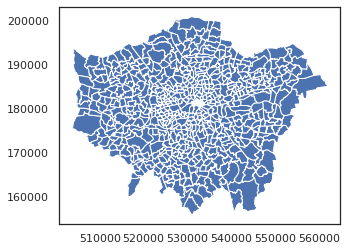

In [114]:
dfward.plot()

In [ ]:
# clean the crime data
dfcrime[dfcrime.isna()]
dfcrime.isnull().sum(axis=0).sort_values(ascending=False)
dfcrime.isnull().sum(axis=1).sort_values(ascending=False)

In [115]:
column_list = list(dfcrime)
column_list.remove("MajorText")
column_list.remove("WardCode")
dfcrime["sum of crime"] = dfcrime[column_list].sum(axis=1)
dfcrime1 = dfcrime[["MajorText","WardCode","sum of crime"]]
dfcrime1.head()

,MajorText,WardCode,sum of crime
0,Arson and Criminal Damage,E05000026,14
1,Arson and Criminal Damage,E05000026,256
2,Burglary,E05000026,142
3,Burglary,E05000026,116
4,Drug Offences,E05000026,12


In [62]:
dfcrime2 = dfcrime1.groupby(['WardCode']).sum()
dfcrime2.head(2)

,sum of crime
WardCode,
E05000026,2886
E05000027,892


In [17]:
# clean the airbnb data
dfair['price'] = dfair.price.str.replace('$','').str.replace(',','').astype(float)
dfair.drop(dfair[((dfair.latitude.isna())|(dfair.longitude.isna()))].index, axis=0, inplace=True)
print(dfair.shape)

(86469, 5)


In [20]:
dfair[dfair.room_type.isna()][['longitude','latitude']]
dfair.isnull().sum(axis=0).sort_values(ascending=False)
dfair.isnull().sum(axis=1).sort_values(ascending=False)

86468    0
28824    0
28816    0
28817    0
28818    0
        ..
57647    0
57648    0
57649    0
57650    0
0        0
Length: 86469, dtype: int64

In [24]:
# clean the population data
dfpop[dfpop.isna()]
dfpop.isnull().sum(axis=0).sort_values(ascending=False)
dfpop.isnull().sum(axis=1).sort_values(ascending=False)

659    0
225    0
223    0
222    0
221    0
      ..
439    0
438    0
437    0
436    0
0      0
Length: 660, dtype: int64

In [23]:
# clean the dwelling data
dfdwe[dfdwe.isna()]
dfdwe.isnull().sum(axis=0).sort_values(ascending=False)
dfdwe.isnull().sum(axis=1).sort_values(ascending=False)

626    0
205    0
212    0
211    0
210    0
      ..
417    0
416    0
415    0
414    0
0      0
Length: 627, dtype: int64

In [116]:
gdfair = gpd.GeoDataFrame(dfair, 
                          geometry=gpd.points_from_xy(dfair.longitude, dfair.latitude, crs='epsg:4326'))
gdfair = gdfair.to_crs('epsg:27700')

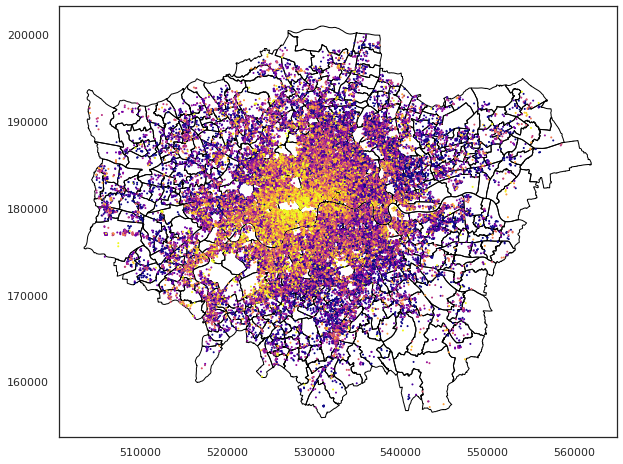

In [117]:
## 画图查看一下上车点在空间上的分布
base = dfward.plot(figsize=(10,10),facecolor='None',edgecolor='Black')
gdfair.plot(ax=base,column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));
plt.show()

In [135]:
dfward = dfward.to_crs(epsg=27700)

0      E05000405
1      E05000414
2      E05000401
3      E05000400
4      E05000402
         ...    
644    E05000002
645    E05000008
646    E05000012
647    E05000021
648    E05000009
Name: GSS_CODE, Length: 649, dtype: object

In [160]:
# wl == Ward Listings
wl = gpd.sjoin(gdfair,dfward,op='within').drop(columns=
    ['latitude','longitude','index_right']
)
wl.head()

,room_type,price,availability_365,geometry,NAME,GSS_CODE
0,Entire home/apt,88.0,0,POINT (530885.122 175377.940),Ferndale,E05000421
942,Entire home/apt,150.0,0,POINT (530452.730 175488.133),Ferndale,E05000421
1109,Entire home/apt,130.0,362,POINT (530497.312 175294.543),Ferndale,E05000421
1138,Entire home/apt,95.0,208,POINT (530733.982 175795.792),Ferndale,E05000421
1442,Entire home/apt,130.0,322,POINT (530790.015 175806.134),Ferndale,E05000421


In [153]:
wl['GSS_CODE']

0        E05000421
942      E05000421
1109     E05000421
1138     E05000421
1442     E05000421
           ...    
54471    E05011471
70593    E05011471
55264    E05009299
59718    E05009299
59719    E05009299
Name: GSS_CODE, Length: 86467, dtype: object

In [217]:
wlgc = wl.groupby(['room_type','GSS_CODE'])['availability_365'].agg(Count='count').reset_index() # ward listings grouped counts
wlgc.head()

,room_type,GSS_CODE,Count
0,Entire home/apt,E05000026,29
1,Entire home/apt,E05000027,4
2,Entire home/apt,E05000028,10
3,Entire home/apt,E05000029,1
4,Entire home/apt,E05000030,1


In [218]:
wlgc = wlgc.pivot(index='GSS_CODE', columns=['room_type'], values=['Count']).reset_index()
wlgc.columns = ['GSS_CODE','Entire home/apt','Hotel room','Private room','Shared room']
wlgc.drop(columns=['Hotel room'], inplace=True)
wlgc.head()

,GSS_CODE,Entire home/apt,Private room
0,E05000026,29.0,37.0
1,E05000027,4.0,10.0
2,E05000028,10.0,5.0
3,E05000029,1.0,11.0
4,E05000030,1.0,10.0


In [219]:
wlg = pd.merge(wlgc,dfpop, left_on='GSS_CODE', right_on='New code',how = 'left')
wlg.drop(columns=['New code'], inplace=True)
wlg.head()

,GSS_CODE,Entire home/apt,Private room,Population - 2015
0,E05000026,29.0,37.0,14750.0
1,E05000027,4.0,10.0,10600.0
2,E05000028,10.0,5.0,12700.0
3,E05000029,1.0,11.0,10400.0
4,E05000030,1.0,10.0,10750.0


In [220]:
wlg = pd.merge(wlg,dfcrime2, left_on='GSS_CODE',right_on = 'WardCode',how = 'left')
wlg.head(3)

,GSS_CODE,Entire home/apt,Private room,Population - 2015,sum of crime
0,E05000026,29.0,37.0,14750.0,2886.0
1,E05000027,4.0,10.0,10600.0,892.0
2,E05000028,10.0,5.0,12700.0,1031.0


In [221]:
wlg = pd.merge(wlg,dfdwe, left_on='GSS_CODE', right_on='New Code',how = 'left')
wlg.drop(columns=['New Code'], inplace=True)
wlg = wlg.fillna(0.01).set_index('GSS_CODE')
wlg.head()

,Entire home/apt,Private room,Population - 2015,sum of crime,Number of dwellings; 2015
GSS_CODE,,,,,
E05000026,29.0,37.0,14750.0,2886.0,5060.0
E05000027,4.0,10.0,10600.0,892.0,4140.0
E05000028,10.0,5.0,12700.0,1031.0,5180.0
E05000029,1.0,11.0,10400.0,1016.0,4060.0
E05000030,1.0,10.0,10750.0,858.0,4060.0


In [222]:
# create x indicator  --   room count/ dwellings number
wlg ['entire room density'] = wlg['Entire home/apt']/wlg['Number of dwellings; 2015']
wlg ['private room density'] = wlg['Private room']/wlg['Number of dwellings; 2015']
wlg1 ['shared room density'] = wlg['Shared room']/wlg['Number of dwellings; 2015']
wlg.head(3)

,Entire home/apt,Private room,Population - 2015,sum of crime,Number of dwellings; 2015,entire room density,private room density
GSS_CODE,,,,,,,
E05000026,29.0,37.0,14750.0,2886.0,5060.0,0.005731,0.007312
E05000027,4.0,10.0,10600.0,892.0,4140.0,0.000966,0.002415
E05000028,10.0,5.0,12700.0,1031.0,5180.0,0.001931,0.000965


In [223]:
wlg.drop(columns=['Entire home/apt','Private room','Shared room','Population - 2015','Number of dwellings; 2015'], inplace=True)
wlg.head(3)

,sum of crime,entire room density,private room density
GSS_CODE,,,
E05000026,2886.0,0.005731,0.007312
E05000027,892.0,0.000966,0.002415
E05000028,1031.0,0.001931,0.000965


In [227]:
for c in wlg.columns.values:
    wlg[c] = pts.fit_transform(wlg[c].values.reshape(-1,1))
wlg.head(3)

In [228]:
wlg.head(3)

,sum of crime,entire room density,private room density
GSS_CODE,,,
E05000026,1.381932,-0.600478,-0.591146
E05000027,-0.287269,-0.605214,-0.596193
E05000028,-0.114265,-0.604253,-0.597694


In [231]:
wlg = pd.merge(wlg,dfward, on='GSS_CODE',how = 'left')
wlg.head(3)

,GSS_CODE,sum of crime,entire room density,private room density,NAME,geometry
0,E05000026,1.381932,-0.600478,-0.591146,Abbey,"POLYGON ((544735.196 184076.498, 544726.596 18..."
1,E05000027,-0.287269,-0.605214,-0.596193,Alibon,"POLYGON ((547932.400 184916.598, 547944.800 18..."
2,E05000028,-0.114265,-0.604253,-0.597694,Becontree,"POLYGON ((546209.396 185783.599, 546219.299 18..."


In [232]:
wlg = gpd.GeoDataFrame(wlg, crs="EPSG:27700", geometry='geometry')

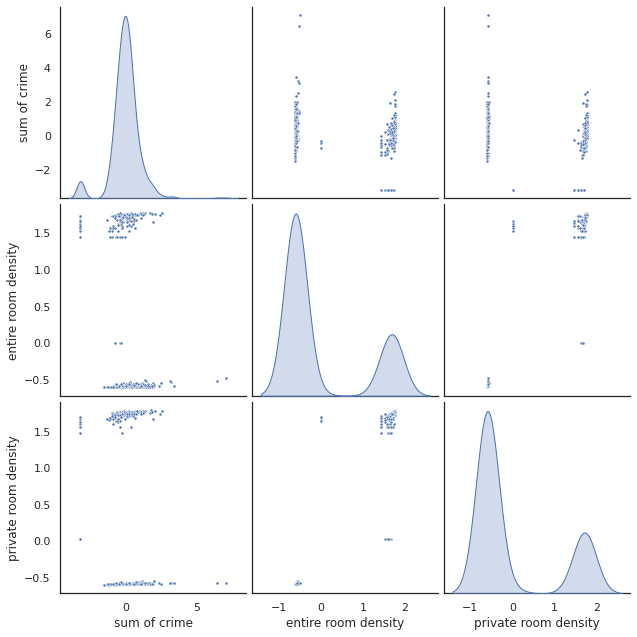

In [229]:
sns.set(style="white")
sns.pairplot(wlg, markers=".", height=3, diag_kind='kde');

In [ ]:
wlg.plot()